In [1]:
import numpy as np
# from scipy.optimize import curve_fit
import sys
import matplotlib.pyplot as plt

import iminuit
print("iminuit version:", iminuit.__version__)
from iminuit import Minuit
from iminuit.cost import LeastSquares
import inspect

iminuit version: 1.5.4


In [2]:
def curve_fit(f, x, y, sigma=None, p0=None):

    if sigma is None:
        sigma = np.ones_like(y)

    init_params = {}
    if not p0 is None:
        for i, n in enumerate(inspect.getfullargspec(f)[0][1:]):
            init_params[n]=p0[i]

    least_squares = LeastSquares(x, y, sigma, f)

    m = Minuit(least_squares, **init_params)

    m.migrad()
    m.hesse()

    return m.np_values(), np.array(m.matrix())

# test
def lin(x,a,b):
        return a*x+b
popt_lin, pcov_lin = curve_fit(lin, range(4), [0,1.1,1.9,3], sigma=[1,1,1,1], p0=[1, 0])
print(popt_lin)
print(pcov_lin)

[0.98 0.03]
[[ 0.2 -0.3]
 [-0.3  0.7]]


In [3]:
## PARAMETERS
# B1 is stationary
# B2 is scanning

params = {
    # "Nominal_LS":1.05,
    "Nominal_LS_B1":1.0,
    # "Nominal_LS_B1":0.995,
    # "Doros_LS_B1":1.05,
    "Doros_LS_B1":1.0,
    # "Doros_LS_B1":0.995,
    # "Arc_LS_B1":1.05,
    "Arc_LS_B1":1.0,
    # "Arc_LS_B1":0.995,
    "Nominal_LS_B2":1.0,
    # "Nominal_LS_B2":0.995,
    # "Doros_LS_B2":1.05,
    "Doros_LS_B2":1.0,
    # "Doros_LS_B2":0.995,
    # "Arc_LS_B2":1.05,
    "Arc_LS_B2":1.0,
    # "Arc_LS_B2":0.995,
    "Sigma_B1":90, #micron
    "Sigma_B2":90, #micron
    "nominal_step_size_B1": 130, #micron
    "nominal_step_size_B2": 130, #micron
    "OD_B1":[
        0,10,0,
        0,0,0,
        0,0,0,
        0,0,0,
        0,0,0,
    ],
    "OD_B2":[
        0,0,0,
        0,0,0,
        0,0,0,
        0,0,0,
        0,0,0,
    ],
    "rate_runcertainty_at_head_on":0.005, 
    "beamspot_position_uncertainty":1, #micron
    # "pos_strategy":"doros, middle point",
    "pos_strategy":"doros, avg point",
}

Text(0, 0.5, 'Beam position')

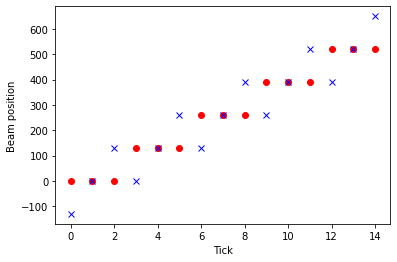

In [4]:
## nominal beampositions

nominal_B1_positions = np.repeat((np.arange(5)*params["nominal_step_size_B1"]),3)
scan_pattern = np.tile([-params["nominal_step_size_B2"], 0, params["nominal_step_size_B2"]], 5)
nominal_B2_positions = nominal_B1_positions + scan_pattern

plt.plot(range(15), nominal_B1_positions, "or")
plt.plot(range(15), nominal_B2_positions, "xb")
plt.xlabel('Tick')
plt.ylabel('Beam position')

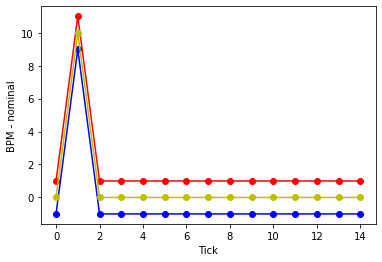

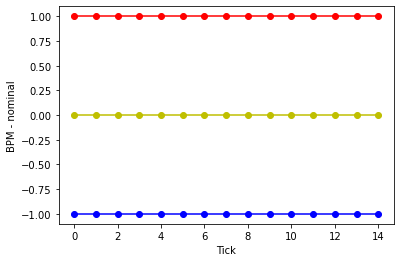

In [5]:
## OD and BPM

true_B1_positions = nominal_B1_positions + params["OD_B1"]
true_B2_positions = nominal_B2_positions + params["OD_B2"]

doros_B1_positions = true_B1_positions * params["Doros_LS_B1"]
doros_B2_positions = true_B2_positions * params["Doros_LS_B2"]

arc_B1_positions = true_B1_positions * params["Arc_LS_B1"]
arc_B2_positions = true_B2_positions * params["Arc_LS_B2"]

avg_B1_positions = (doros_B1_positions + arc_B1_positions)/2
avg_B2_positions = (doros_B2_positions + arc_B2_positions)/2


plt.plot(range(15), doros_B1_positions-nominal_B1_positions+1, "o-r")
plt.plot(range(15), arc_B1_positions-nominal_B1_positions-1, "o-b")
plt.plot(range(15), avg_B1_positions-nominal_B1_positions, "o-y")
plt.xlabel('Tick')
plt.ylabel('BPM - nominal')
plt.show()

plt.plot(range(15), doros_B2_positions-nominal_B2_positions+1, "o-r")
plt.plot(range(15), arc_B2_positions-nominal_B2_positions-1, "o-b")
plt.plot(range(15), avg_B2_positions-nominal_B2_positions, "o-y")
plt.xlabel('Tick')
plt.ylabel('BPM - nominal')
plt.show()


In [6]:
## OD correction of nominal

# this part needs to compute the followings:
# analysis_B1_positions
# analysis_B2_positions
# analysis_B1_5positions


# def avg_stepsize_corr(positions, remove_outliers=False):

#     if not remove_outliers:
#         return np.mean(  )


if params["pos_strategy"]=="doros, middle point":
    analysis_B1_positions  = doros_B1_positions
    analysis_B2_positions  = doros_B2_positions
    analysis_B1_5positions = doros_B1_positions[1::3]
elif params["pos_strategy"]=="doros, avg point":
    analysis_B1_positions  = doros_B1_positions
    analysis_B2_positions  = doros_B2_positions
    analysis_B1_5positions = np.array([ np.mean(doros_B1_positions[3*i:3*i+3]) for i in range(5)])
# elif params["pos_strategy"]=="doros-avgstepsize+nominal, middle point":
#     analysis_B1_positions  = nominal_B1_positions + doros_B1_positions - avg_stepsize_corr(doros_B1_positions, remove_outliers=False)
#     analysis_B2_positions  = nominal_B2_positions + doros_B2_positions - avg_stepsize_corr(doros_B2_positions, remove_outliers=False)
#     analysis_B1_5positions = np.array([ np.mean(doros_B1_positions[3*i:3*i+3]) for i in range(5)])
# elif params["pos_strategy"]=="doros-avgstepsize+nominal, avg point":
#     analysis_B1_positions  = nominal_B1_positions + doros_B1_positions - avg_stepsize_corr(doros_B1_positions, remove_outliers=False)
#     analysis_B2_positions  = nominal_B2_positions + doros_B2_positions - avg_stepsize_corr(doros_B2_positions, remove_outliers=False)
#     analysis_B1_5positions = np.array([ np.mean(doros_B1_positions[3*i:3*i+3]) for i in range(5)])


    


Text(0, 0.5, 'Beam position / bs position')

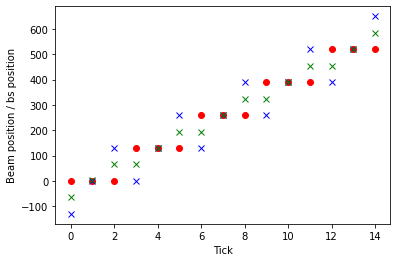

In [7]:
## beamspot location 
true_beamspot_positions = ( 
        true_B1_positions/params["Sigma_B1"]**2 + 
        true_B2_positions/params["Sigma_B2"]**2
    )/(params["Sigma_B1"]**-2+params["Sigma_B2"]**-2)


plt.plot(range(15), nominal_B1_positions, "or")
plt.plot(range(15), nominal_B2_positions, "xb")
plt.plot(range(15), true_beamspot_positions, "xg")
plt.xlabel('Tick')
plt.ylabel('Beam position / bs position')

In [8]:
## rates
true_rates     = np.exp(-0.5 * (true_B1_positions-true_B2_positions)**2 / (params["Sigma_B1"]**2+params["Sigma_B2"]**2) )
true_rates_unc = true_rates**0.5 * np.max(true_rates)**0.5 * params["rate_runcertainty_at_head_on"]

In [9]:
## calculate head-on beamspot position

def get_headon_position(rates, rate_unc, separations, beamspot_positions ):

    def sg(x,a,m,s):
        return a*np.exp(-0.5*((x-m)/s)**2)
    
    popt_sg, pcov_sg = curve_fit(sg, separations, rates, sigma=rate_unc, p0=[np.max(rates), 0, separations[1] - separations[0] ])
    mu               = popt_sg[1]

    def lin(x,a,b):
        return a*x+b

    popt_lin, pcov_lin = curve_fit(lin, separations, beamspot_positions, sigma=[params["beamspot_position_uncertainty"]]*3, p0=[1, 0])
    a = popt_lin[0]
    b = popt_lin[1]

    # compute result uncertainty
    if np.allclose(pcov_lin, 0):
        std = a*pcov_sg[1,1]**0.5
    else:
        mu_randomized = mu + pcov_sg[1,1]**0.5*np.random.normal(size=1000)
        try:
            pcov_lin_sqrt = np.linalg.cholesky(pcov_lin)
        except Exception as e:
            print(e)
            print(pcov_lin)
            sys.exit()

        ab_randomized = popt_lin[:,np.newaxis] + np.einsum("ij,jk", pcov_lin_sqrt, np.random.normal(size=(2,1000)))
        std = np.std( ab_randomized[0,:]*mu_randomized + ab_randomized[1,:] )

    if std == 0:
        std = 1e-6

    return a*mu+b, std


computed_head_on_bs_position = []
computed_head_on_bs_position_unc = []
for i in range(5):

    v, u = get_headon_position(
        true_rates[3*i:3*i+3],
        true_rates_unc[3*i:3*i+3],
        analysis_B1_positions[3*i:3*i+3] - analysis_B2_positions[3*i:3*i+3],
        true_beamspot_positions[3*i:3*i+3])
    computed_head_on_bs_position.append(v) 
    computed_head_on_bs_position_unc.append(u)

print(computed_head_on_bs_position)
print(computed_head_on_bs_position_unc)

[3.326513227402067, 130.00000000658258, 259.99999997927654, 390.0000001424202, 519.9999996814157]
[0.6390227706355709, 0.6511884332432667, 0.6437078714406992, 0.6070397097825914, 0.631877885432823]


1.00001052729969


Text(0, 0.5, 'Beam position')

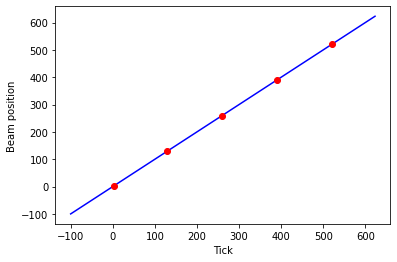

In [10]:
def lin(x,a,b):
        return a*x+b

a0 = (computed_head_on_bs_position_unc[-1]-computed_head_on_bs_position_unc[0])/(analysis_B1_5positions[-1]-analysis_B1_5positions[0])
b0 = 0
popt_lin, pcov_lin = curve_fit(lin, analysis_B1_5positions, computed_head_on_bs_position, sigma=computed_head_on_bs_position_unc, p0=[a0, b0])
a = popt_lin[0]
b = popt_lin[1]

print(a)

liml = np.min(analysis_B1_5positions) - 0.2 * (np.max(analysis_B1_5positions)-np.min(analysis_B1_5positions))
limu = np.max(analysis_B1_5positions) + 0.2 * (np.max(analysis_B1_5positions)-np.min(analysis_B1_5positions))
x = np.linspace(liml, limu, 2)
plt.plot(x, lin(x,a,b), "b-")
plt.errorbar(analysis_B1_5positions, computed_head_on_bs_position, yerr=computed_head_on_bs_position_unc, fmt="or")


plt.xlabel('Tick')
plt.ylabel('Beam position')